# MIMO — Multi-Input Multi-Output Networks

### Introduction

In machine learning there are a few problems, one of them is confident misprediction. <br>
One solutions to tackle this problem are ensembles which use a base model multiple times to lower uncertainty for the prediction. <br>
There are different ways to use the output of the ensemble members but this topic is not part of this notebook. <br>
The problem with ensembles is there high cost because of training the members of the ensemble separately. One way to tackle this problem is to use MIMO (multi-input-multi-output) configuration. <br>
For further information: [Training independent subnetwroks for robust prediction](https://openreview.net/pdf?id=OGg9XnKxFAH)

### What is a MIMO ?

A MIMO uses mulitple inputs and outputs which can train subnetworks of the main network concurrently. By using this we get "free" forward passes while testing and leveraging the outputs similar to an ensemble. This method uses less computational cost and has the benefits of an ensemble.

### How to test performance ?

In the rest of the notebook is a short demo and comparison between a MIMO and an ensemble. Note, that this setup is not ideal. 

## 1. Quick Setup

In [ ]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)  # oqa E702
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

## 2. Toy dataset (classification variant)

Make use of a simple moon dataset from sklearn to have fast training time. Splitting the dataset in 80% training data and 20% evalulation data and making the data ready in batch sizes of 128 for training and evalulation

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=30000, noise=0.2, random_state=seed)
X = X.astype("float32")
y = y.astype("int64")

split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_ds), "Val size:", len(val_ds))

## 3. Baseline model (standard MLP)

Creating a MLP to use as a base model for the ensemble to have a fast training time.
 

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim: int = 2, hidden: int = 128, out_dim: int = 2) -> None:
        """MLP with two hidden layers."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Simple forward."""
        return self.net(x)


m = MLP().to(device)
print(m)

## 4. MIMO wrapper: make an M-input M-output version of the MLP

Changing my MLP model to have an input layer to accept the M inputs and M heads for the different subnetworks. The output of the different heads is stacked into one dimension.


In [ ]:
class MIMO(nn.Module):
    def __init__(self, base_hidden: int = 128, in_dim: int = 2, out_dim: int = 2, M: int = 3) -> None:  # noqa: N803
        """MIMO model with M outputs."""
        super().__init__()
        self.M = M
        self.input_layer = nn.Linear(in_dim * M, base_hidden)
        self.body = nn.Sequential(
            nn.ReLU(),
            nn.Linear(base_hidden, base_hidden),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList([nn.Linear(base_hidden, out_dim) for _ in range(M)])

    def forward(self, x_concat: torch.Tensor) -> torch.Tensor:
        """Forward pass with concatenated inputs."""
        h = self.input_layer(x_concat)
        h = self.body(h)
        outs = [head(h) for head in self.heads]
        outs = torch.stack(outs, dim=1)
        return outs


mimo_model = MIMO(M=3).to(device)
print(mimo_model)

## 5. Comparison between Ensemble and MIMO-Idea

Training an Ensemble and a MIMO to compare acc, loss, ece, MI(disagreement), forward calls.
The number of subnetworks is four as recommended in [TRAINING INDEPENDENT SUBNETWORKS FOR ROBUST
PREDICTION](https://openreview.net/pdf?id=OGg9XnKxFAH)
 
Setup:

dataset with 24k datapoints to train and 6k datapoints for evalulation <br>
K members in ensemble = 3 <br>
K subnetworks in the MIMO = 3 <br> 
Epochs = 10 <br>
lr = 1e-3 <br>

In [ ]:
# Small experiments: train MIMO and an ensemble with comparable capacity
k = 3
epochs = 10
lr = 1e-3


def softmax_np(logits: np.ndarray, axis: int = -1) -> np.ndarray:
    e = np.exp(logits - logits.max(axis=axis, keepdims=True))
    return e / e.sum(axis=axis, keepdims=True)


def entropy_np(probs: np.ndarray, axis: int = -1, eps: float = 1e-12) -> np.ndarray:
    p = np.clip(probs, eps, 1.0)
    return -np.sum(p * np.log(p), axis=axis)


def ece_score(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15) -> float:
    # probs: (N, C) predictive mean probs; labels: (N,)
    confs = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    n = len(labels)
    for i in range(n_bins):
        mask = (confs >= bins[i]) & (confs < bins[i + 1])
        if mask.sum() == 0:
            continue
        acc = (preds[mask] == labels[mask]).mean()
        conf = confs[mask].mean()
        ece += (mask.sum() / n) * abs(conf - acc)
    return float(ece)


def reliability_diagram(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15, ax: None = None) -> plt.Axes:
    confs = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    accs = []
    avg_confs = []
    counts = []
    for i in range(n_bins):
        mask = (confs >= bins[i]) & (confs < bins[i + 1])
        counts.append(mask.sum())
        if mask.sum() == 0:
            accs.append(np.nan)
            avg_confs.append(np.nan)
        else:
            accs.append((preds[mask] == labels[mask]).mean())
            avg_confs.append(confs[mask].mean())
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(bin_centers, accs, marker="o", label="accuracy per bin")
    ax.plot([0, 1], [0, 1], "--", color="gray")
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title("Reliability diagram")
    return ax


# Train a normal ensemble of K independently initialized MLPs
def train_ensemble(
    base_cls: nn.Module,
    k: int,
    train_loader: DataLoader,
    epochs: int = epochs,
    lr: float = 1e-3,
) -> list:
    models = []
    ensemble_forward_calls = 0
    for _ in range(k):
        print(f"\nTraining ensemble member {_ + 1}/{k}")
        m_k = base_cls().to(device)
        opt = optim.Adam(m_k.parameters(), lr=lr)
        lossfn = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            m_k.train()
            for xb, yb in train_loader:
                x = xb.to(device).float()
                y = yb.to(device).long()
                opt.zero_grad()
                ensemble_forward_calls += 1
                out = m_k(x)
                loss = lossfn(out, y)
                loss.backward()
                opt.step()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
        models.append(m_k)

    print(f"Ensemble total forward calls: {ensemble_forward_calls}")
    return models


def train_mimo(
    mimo_model: nn.Module,
    train_loader: DataLoader,
    epochs: int = epochs,
    lr: float = lr,
    m: int = k,
) -> nn.Module:
    opt = torch.optim.Adam(mimo_model.parameters(), lr=lr)
    lossfn = torch.nn.CrossEntropyLoss()
    forward_calls = 0  # Zähler

    for epoch in range(epochs):
        mimo_model.train()
        for xb, yb in train_loader:
            x = xb.to(device).float()
            y = yb.to(device).long()
            opt.zero_grad()

            forward_calls += 1
            xb_cat = x.repeat(1, m)
            out = mimo_model(xb_cat)

            # Mittelwert über die M Heads für Loss
            out_mean = out.view(out.size(0), m, -1).mean(dim=1)
            loss = lossfn(out_mean, y)
            loss.backward()
            opt.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    print(f"MIMO total forward calls: {forward_calls}")
    return mimo_model


# Evaluation helpers
def eval_ensemble_models(models: list, x_np: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # returns mean_probs (N, C), member_probs (N, K, C)
    x = torch.from_numpy(x_np).to(device).float()
    member_probs = []
    for m in models:
        m.eval()
        with torch.no_grad():
            logits = m(x).cpu().numpy()
            member_probs.append(softmax_np(logits))
    member_probs = np.stack(member_probs, axis=1)  # (N, K, C)
    mean_probs = member_probs.mean(axis=1)
    return mean_probs, member_probs


def eval_mimo_model(mimo_model: nn.Module, x_np: np.ndarray, m: int) -> tuple[np.ndarray, np.ndarray]:
    # For MIMO we feed the same input concatenated M times to get M heads' outputs
    x = torch.from_numpy(x_np).to(device).float()
    x_cat = x.repeat(1, m)  # (N, feat*M)
    mimo_model.eval()
    with torch.no_grad():
        logits = mimo_model(x_cat).cpu().numpy()  # (N, M, C)
    member_probs = softmax_np(logits, axis=-1)  # (N, M, C)
    mean_probs = member_probs.mean(axis=1)  # (N, C)
    return mean_probs, member_probs

### Training

Training and tracking time needed to train and displaying the results in differetn plots.


In [ ]:
# train mimo_model for fairness
start = time.time()
train_mimo(mimo_model, train_loader, epochs=epochs, lr=lr, m=k)
mimo_time = time.time() - start

# train K independent MLPs
start = time.time()
ensemble_models = train_ensemble(MLP, k, train_loader, epochs=epochs, lr=lr)
ensemble_time = time.time() - start

# Eval on validation set
X_val_np = X_val.astype("float32")
y_val_np = y_val.astype("int64")

mimo_mean, mimo_members = eval_mimo_model(mimo_model, X_val_np, m=k)
ens_mean, ens_members = eval_ensemble_models(ensemble_models, X_val_np)


# Metrics
def print_metrics(name: str, mean_probs: np.ndarray) -> None:
    acc = accuracy_score(y_val_np, mean_probs.argmax(axis=1))
    nll = log_loss(y_val_np, mean_probs)
    ece = ece_score(mean_probs, y_val_np, n_bins=15)
    print(f"{name} — acc: {acc:.4f}, nll: {nll:.4f}, ece: {ece:.4f}")


print_metrics("MIMO", mimo_mean, mimo_members)
print_metrics("Ensemble", ens_mean, ens_members)

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) Reliability diagrams
ax = axes[0, 0]
reliability_diagram(mimo_mean, y_val_np, n_bins=15, ax=ax)
ax.set_title("MIMO Reliability")
ax = axes[0, 1]
reliability_diagram(ens_mean, y_val_np, n_bins=15, ax=ax)
ax.set_title("Ensemble Reliability")

# 2) Decision boundary (mean-predictive probability for class 1)
ax = axes[1, 0]
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 200),
)
grid = np.stack([xx.ravel(), yy.ravel()], axis=1).astype("float32")
mimo_grid_mean, _ = eval_mimo_model(mimo_model, grid, m=k)
ens_grid_mean, _ = eval_ensemble_models(ensemble_models, grid)
cs = ax.contourf(xx, yy, mimo_grid_mean[:, 1].reshape(xx.shape), levels=20, cmap="RdBu", alpha=0.6)
ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=12, cmap="RdBu", edgecolor="k", alpha=0.8)
ax.set_title("MIMO mean prob (class 1)")
ax = axes[1, 1]
cs = ax.contourf(xx, yy, ens_grid_mean[:, 1].reshape(xx.shape), levels=20, cmap="RdBu", alpha=0.6)
ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=12, cmap="RdBu", edgecolor="k", alpha=0.8)
ax.set_title("Ensemble mean prob (class 1)")

plt.tight_layout()
plt.show()


# Barplot: MIMO vs Ensemble in Metrics
def get_metrics_tuple(mean_probs: np.ndarray, member_probs: np.ndarray) -> tuple:
    acc = accuracy_score(y_val_np, mean_probs.argmax(axis=1))
    nll = log_loss(y_val_np, mean_probs)
    ece = ece_score(mean_probs, y_val_np, n_bins=15)
    h_mean = entropy_np(mean_probs)
    h_members = entropy_np(member_probs, axis=-1).mean(axis=1)
    mi = (h_mean - h_members).mean()
    return acc, nll, ece, mi


mimo_metrics = get_metrics_tuple(mimo_mean, mimo_members)
ensemble_metrics = get_metrics_tuple(ens_mean, ens_members)

metrics_names = ["Accuracy", "NLL", "ECE", "Mutual Information"]
mimo_values = mimo_metrics
ens_values = ensemble_metrics

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width / 2, mimo_values, width, label="MIMO")
rects2 = ax.bar(x + width / 2, ens_values, width, label="Ensemble")

ax.set_ylabel("Value")
ax.set_title("Metriken: MIMO vs Ensemble")
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

plt.show()

# barplot: time to train MIMO vs Ensemble
if "mimo_time" in globals() and "ensemble_time" in globals():
    plt.figure(figsize=(6, 4))
    plt.bar(["MIMO", "Ensemble"], [mimo_time, ensemble_time], color=["skyblue", "salmon"])
    plt.ylabel("Sekunden")
    plt.title("Trainingszeit MIMO vs Ensemble")

    for i, t in enumerate([mimo_time, ensemble_time]):
        plt.text(i, t + 0.01, f"{t:.2f}s", ha="center")

    plt.show()

Comment: We see that MIMO has nearly 1/3 of the forward calls. Note, that the acc, nll, ece-score is nearly the same, while time to train is less. This would scale on larger models and heavier datasets like seen in the CIFAR experiment below.

## Experiment with CIFAR

Here we use the CIFAR dataset to train our ensemble and MIMO model. This training takes alot longer than the sklearn dataset but shows us a similar result.

Training the models Cifarnet and CifarMIMO would take alot longer than the Sklearn moon dataset because they are images, more datapoints and deeper models than our standard MLP/MIMO-MLP

The result of training over 250 epochs on the ensemble of CIFARNet and CIFAR-MIMO:

- Forward calls for MIMO model: 391 <br>
- Forward calls for member : 7820 <br>
- MIMO — acc: 0.6311, nll: 1.5437, ece: 0.1064, MI(disagreement): 0.3061 <br>
- Ensemble — acc: 0.6991, nll: 1.2719, ece: 0.0767, MI(disagreement): 0.2827 <br>
- MIMO Training dauerte: 428.60 Sekunden <br>
- Ensemble Training dauerte: 1297.08 Sekunden <br>

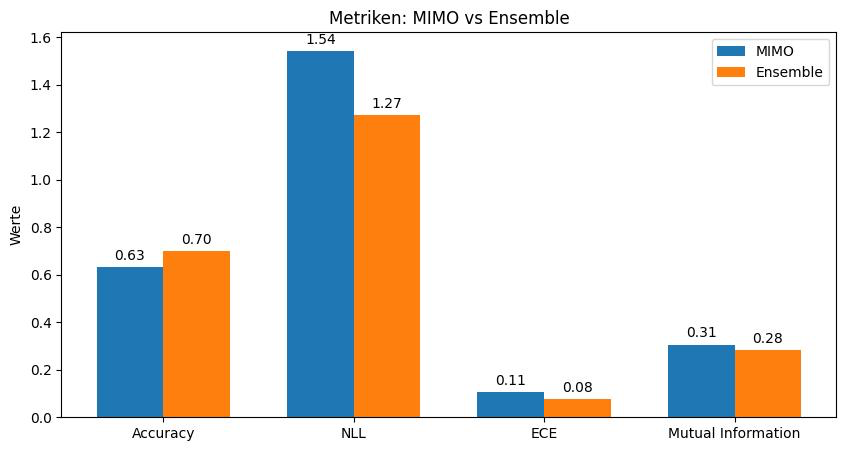
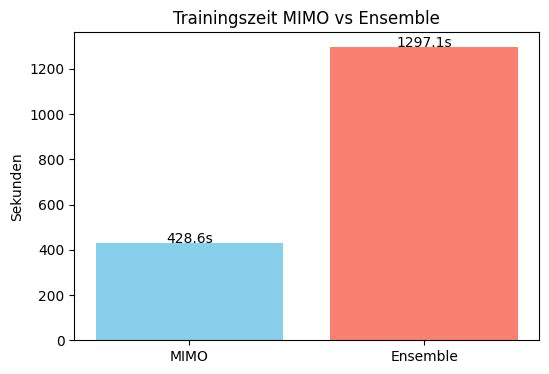

### Conclusion and ideas for probly

In this Notebook we:

- showed with our examples that MIMO can perform similar to a standard ensemble by only changing a few layers from our base model. <br>
- But note, that these examples are only visualizations and there is alot to be careful with to get the wanted effect of the MIMO model like the ensembles which are not disscussed. <br>

For further information: [TRAINING INDEPENDENT SUBNETWORKS FOR ROBUST
PREDICTION](https://openreview.net/pdf?id=OGg9XnKxFAH)

Ideas for probly:

Having MIMO would be an extra for subensembles to get more variance in the heads because of the multi-input which is not available for typical SubEnsemble. <br>
One could have a Subensemble and change it into an MIMO by changing the input layer to create more robustness for prediction. 